# TriMeshes



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## TriMesh



In [2]:
from quagmire import FlatMesh 
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

x1, y1, bmask1 = meshtools.poisson_elliptical_mesh(minX, maxX, minY, maxY, 0.1, 500, r_grid=None)



In [3]:
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask1, refinement_steps=2)
mesh = SurfaceProcessMesh(DM)  ## cloud array etc can surely be done better ... 


0 - Delaunay triangulation 0.117038s
0 - Calculate node weights and area 0.002866s
0 - Find boundaries 0.001489s
0 - cKDTree 0.011674s
0 - Construct neighbour cloud array 0.379039s
0 - Construct rbf weights 0.09459s


In [4]:
x = mesh.coords[:,0]
y = mesh.coords[:,1]
bmask = mesh.bmask

radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(10.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)

rainfall = np.ones_like(height)
rainfall[np.where( radius > 5.0)] = 0.0 

mesh.downhill_neighbours = 2
mesh.update_height(height)


0 - Compute slopes 0.103685s
0 - Build downhill matrices 0.280415s


In [5]:
mo1 = mesh.identify_outflow_points()
i = np.argsort(theta[mo1])
outflows = mo1[i]

In [6]:
mesh.downhill_neighbours = 2
mesh.update_height(height)

flowpaths = mesh.cumulative_flow(rainfall*mesh.area)
logpaths = np.log10(flowpaths)
sqrtpaths = np.sqrt(flowpaths)

mesh.downhill_neighbours = 3
mesh.update_height(height)


flowpaths3 = mesh.cumulative_flow(rainfall*mesh.area)
logpaths3 = np.log10(flowpaths3)
sqrtpaths3 = np.sqrt(flowpaths3)

mesh.downhill_neighbours = 1
mesh.update_height(height)

flowpaths1 = mesh.cumulative_flow(rainfall*mesh.area)
logpaths1 = np.log10(flowpaths1)
sqrtpaths1 = np.sqrt(flowpaths1)


0 - Compute slopes 0.118729s
0 - Build downhill matrices 0.266599s
DHmat**2
DHmat**2 - done 


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


0 - Compute slopes 0.096157s
0 - Build downhill matrices 0.339406s
DHmat**2

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10



DHmat**2 - done 
0 - Compute slopes 0.107757s
0 - Build downhill matrices 0.248677s
DHmat**2
DHmat**2 - done 


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10


In [7]:
## What's happening with the outflow points - how to find them ? 
"""
circum_points = np.where( np.abs(radius-4.9) <= 0.001 )[0]
circum_angle = theta[circum_points]

circum_flow_1 = flowpaths1[circum_points]
circum_flow_2 = flowpaths[circum_points]
circum_flow_3 = flowpaths3[circum_points]

circum_flow_1n = flowpaths_noise1[circum_points]
circum_flow_2n = flowpaths_noise[circum_points]
circum_flow_3n = flowpaths_noise3[circum_points]
"""
pass

In [8]:
# Choose a scale to plot all six flow results
fmax = 1.0

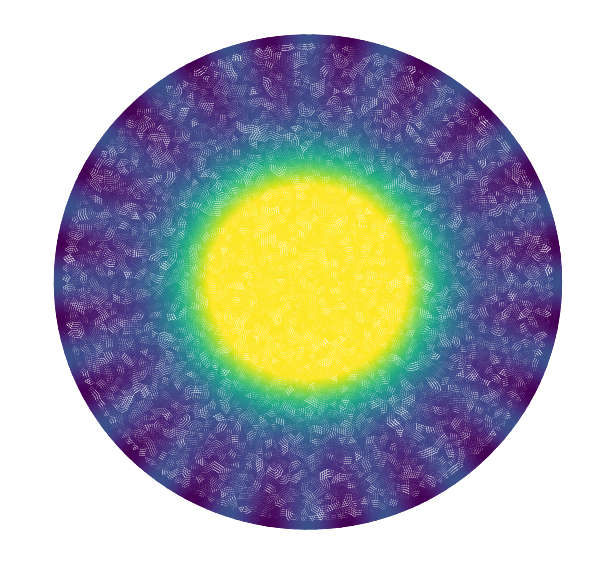

In [15]:
from scipy import ndimage

fig = plt.figure(1, figsize=(10.0, 10.0))
ax = fig.add_subplot(111)
ax.axis('off')
sc = ax.scatter(x[bmask], y[bmask], s=1, c=mesh.height[bmask], vmin=0.0, vmax=1.0)
sc = ax.scatter(x[~bmask], y[~bmask], s=5, c=mesh.height[~bmask], vmin=0.0, vmax=1.0)

# fig.colorbar(sc, ax=ax, label='height')
plt.show()

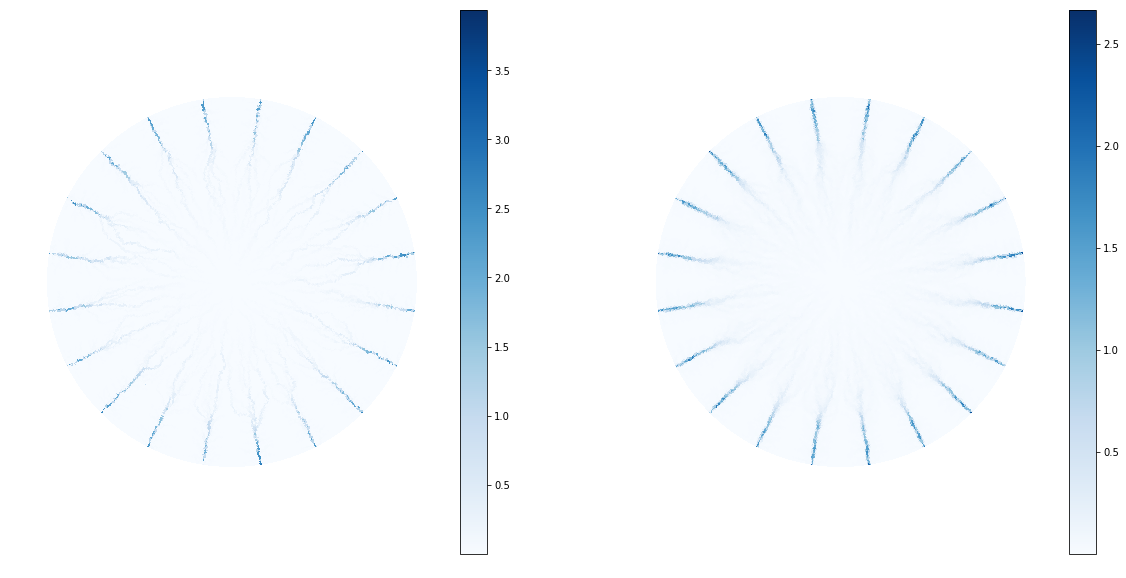

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
    
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, flowpaths1 ,     cmap='Blues')
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, flowpaths,       cmap="Blues")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [9]:
# print mesh.height[mesh.neighbour_cloud[0].compressed()]
# print np.argmin(mesh.height[mesh.neighbour_cloud[0].compressed()])

In [ ]:
hnear = np.ma.array(mesh.height[mesh.neighbour_cloud], mask=mesh.near_neighbours_mask)
low_neighbours = np.argmin(hnear, axis=1)

hnear = np.ma.array(mesh.height[mesh.neighbour_cloud], mask=mesh.extended_neighbours_mask)
low_eneighbours = np.argmin(hnear, axis=1)


np.where(low_eneighbours == 0)

In [ ]:
print mesh.height[mesh.down_neighbour[1][node]] - mesh.height[node], mesh.near_neighbours[node]

In [ ]:
deltah = np.ma.array(mesh.height[mesh.neighbour_cloud] - mesh.height.reshape(-1,1), mask = mesh.neighbour_cloud.mask)

In [ ]:
ind = np.indices(mesh.neighbour_cloud.shape)[1]
mask = ind > mesh.near_neighbours.reshape(-1,1)

In [ ]:
mesh.gaussian_dist_w.shape

In [ ]:
near_neighbours = np.ma.array(mesh.neighbour_cloud, mask=mesh.near_neighbours_mask)
print near_neighbours[0]

In [ ]:
%%timeit
for i in range(0, mesh.npoints):
    np.unique(near_neighbours[near_neighbours[i].compressed()].compressed())

In [ ]:
np.sort(mesh.neighbour_cloud[0].compressed())

In [ ]:
import petsc4py

In [ ]:
xx = np.linspace(minX, maxX, 250)
yy = np.linspace(minY, maxY, 150)
x1, y1 = np.meshgrid(xx,yy)

x1 += np.random.random(x1.shape) * 0.05 * (maxX-minX) / 250.0
y1 += np.random.random(y1.shape) * 0.05 * (maxY-minY) / 150.0

x1 = x1.flatten()
y1 = y1.flatten()

pts = np.stack((x1, y1)).T


In [ ]:
x1.shape